# Hotel Booking Cancellation Prediction - Model Selection

This notebook explores the classification of hotel booking cancellations using three supervised machine learning models: **Logistic Regression**, **Decision Tree**, and **Random Forest**. The goal is to accurately predict whether a booking will be canceled based on customer, booking, and hotel-related features.

The process includes:
- Data cleaning and feature engineering
- Model training and evaluation
- Comparison of model performance metrics (Accuracy, Precision, Recall, F1-Score, AUC)

This work enables better decision-making for hotel management teams by identifying factors that contribute to cancellations, ultimately helping reduce no-shows and optimize booking strategies.

**IMPORTANT:** Make sure to change your file path under the **'Load and Clean the Data'** section to match your local directory.


### Import Libraries

In [1]:
# Import all the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

### Load and Clean the Data

In [3]:
# IMPORTANT: Replace this with the full path to your hotel_bookings.csv file
df = pd.read_csv(r"C:\Path\To\Your\hotel_bookings.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Drop columns not useful for our prediction
df = df.drop(columns=['agent', 'company'])

# Remove entries with undefined market segment
df = df[df['market_segment'] != 'Undefined']

# Create a proper datetime column from year, month, and day columns
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)

# Create total_nights and total_guests as helpful new features
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['total_guests'] = (df['adults'] + df['children'].fillna(0) + df['babies']).astype(int)

### Define Features and Target

In [4]:
# Select which features we want to use and our target variable
features = [
    'lead_time', 'total_nights', 'total_guests', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests',
    'hotel', 'meal', 'market_segment', 'distribution_channel',
    'reserved_room_type', 'deposit_type', 'customer_type'
]

target = 'is_canceled'  # Our prediction goal

X = df[features]
y = df[target]

### Preprocessing Pipeline

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
 
# Identify which features are numeric and which are categorical
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
 
# Standardize numeric features, one-hot encode categorical ones
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
 
# Combine both transformations into one
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Split the Data

In [6]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Train Models

In [7]:
# Define the models we want to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Dictionary to store results for each model
results = {}

### Train + Evaluate Models

In [8]:
# Loop through each model, train it, and record metrics
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions and get probabilities
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Save performance metrics to compare later
    results[name] = {
        'Accuracy': pipeline.score(X_test, y_test),
        'Precision (1)': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall (1)': classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
        'F1 Score (1)': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

### Show Comparison Table

In [9]:
# Convert results into a DataFrame for easier comparison
comparison = pd.DataFrame(results).T
comparison = comparison[['Accuracy', 'Precision (1)', 'Recall (1)', 'F1 Score (1)', 'ROC AUC']]

# Display the table
print("Model Comparison:\n")
display(comparison)

Model Comparison:



,Accuracy,Precision (1),Recall (1),F1 Score (1),ROC AUC
Logistic Regression,0.7854,0.699733,0.382243,0.494406,0.793436
Decision Tree,0.743807,0.533375,0.53293,0.533153,0.682491
Random Forest,0.79175,0.649767,0.523551,0.579871,0.820614


### Plot Confusion Matrices

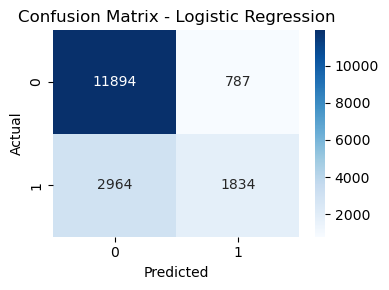

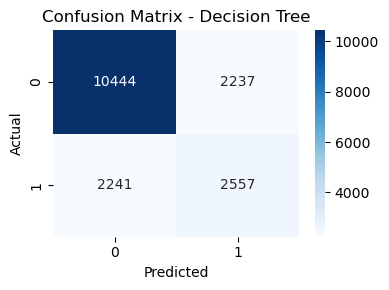

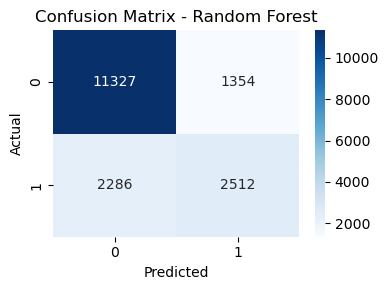

In [10]:
# Visualize confusion matrix for each model
for name, metrics in results.items():
    cm = metrics['Confusion Matrix']
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

### ROC Curves

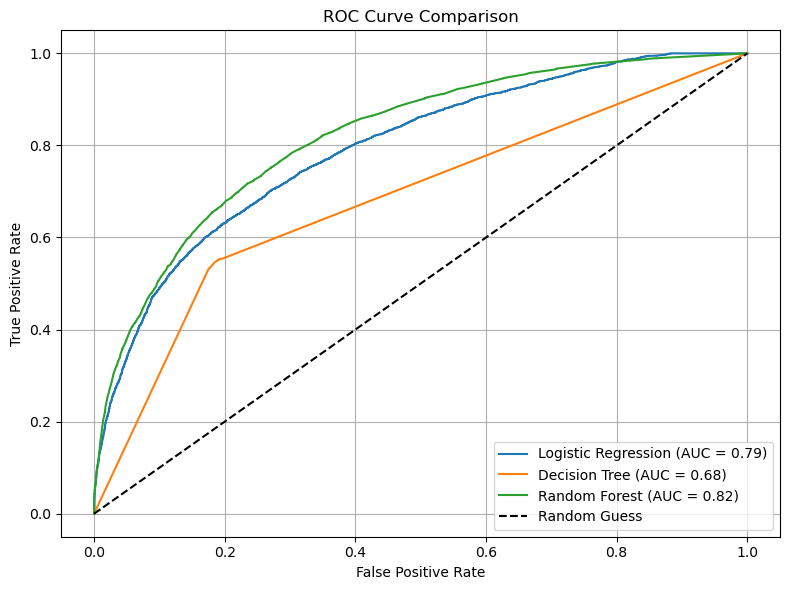

In [11]:
# Plot ROC Curves

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Loop through the already trained pipelines
for name, metrics in results.items():
    model = models[name]
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Labels and legend
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### ROC Curve Interpretation

The ROC curve visually compares the classification performance of the three models:

- **Random Forest** shows the best performance with an AUC of **0.82**, indicating strong ability to distinguish between canceled and non-canceled bookings.
- **Logistic Regression** follows with an AUC of **0.79**, performing moderately well.
- **Decision Tree** performs the weakest with an AUC of **0.68**, suggesting poorer discrimination.

The further the curve bends toward the top-left corner, the better the model's true positive rate vs. false positive rate. Hence, Random Forest is the most reliable model based on ROC AUC and visual inspection.


### Top 10 Features for Each Model

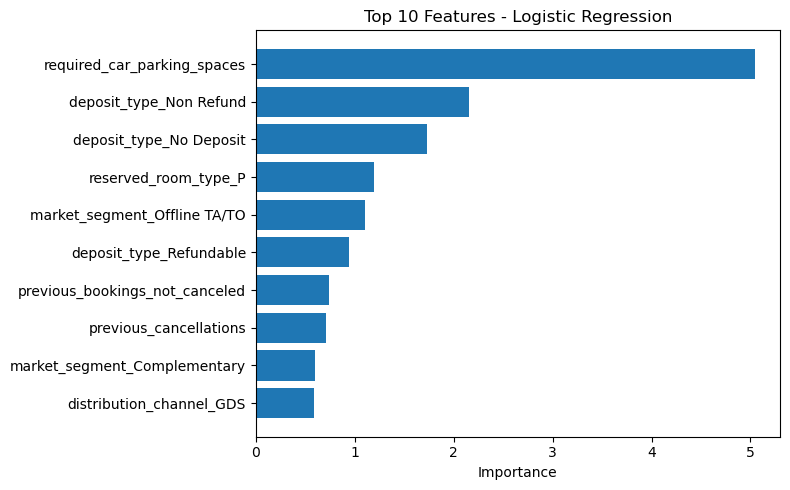

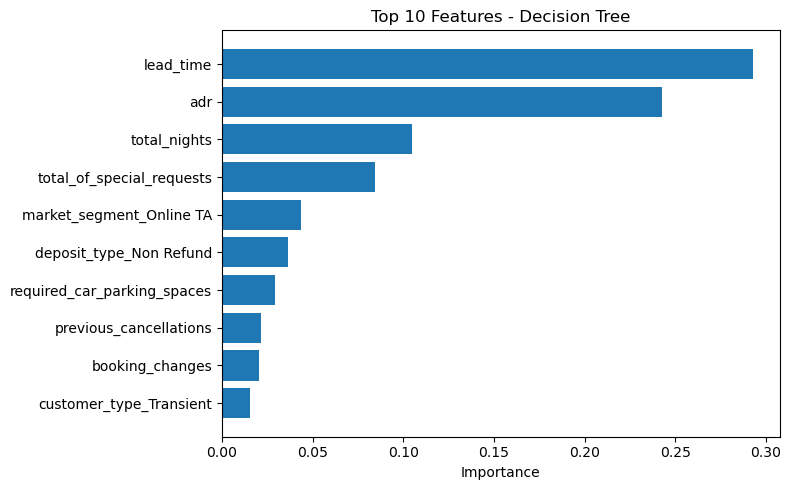

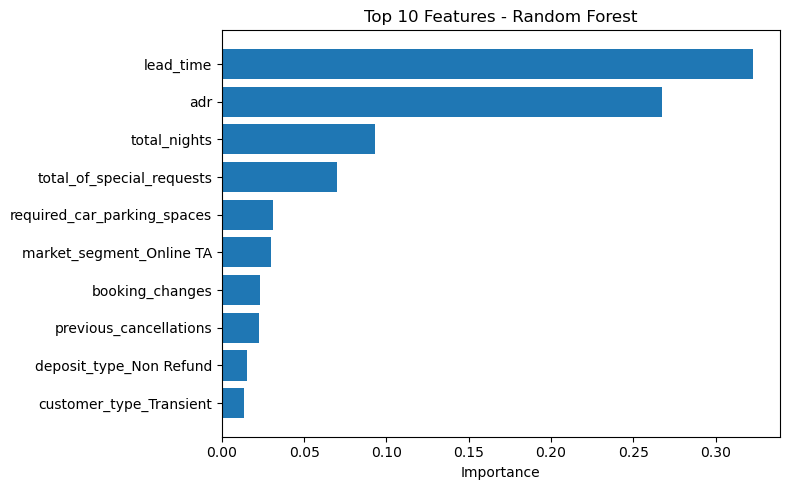

In [12]:
# Get Feature Names After Preprocessing
# Fit preprocessor on the training data
preprocessor.fit(X_train)

# Extract transformed feature names
numeric_features_transformed = numeric_features
categorical_features_transformed = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features_transformed, categorical_features_transformed])

# Function to Plot Top N Features
def plot_top_features(importances, feature_names, model_name, top_n=10):
    top_indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(8, 5))
    plt.barh(range(top_n), importances[top_indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
    plt.title(f"Top {top_n} Features - {model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Feature Importance for Each Model
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)

    if name == "Logistic Regression":
        # Coefficients
        coefs = pipeline.named_steps['classifier'].coef_[0]
        plot_top_features(np.abs(coefs), all_features, name)
    elif name in ["Decision Tree", "Random Forest"]:
        # Feature Importances
        importances = pipeline.named_steps['classifier'].feature_importances_
        plot_top_features(importances, all_features, name)


### Model Selection Summary

After comparing Logistic Regression, Decision Tree, and Random Forest classifiers, we selected **Random Forest** as the best model based on several key metrics:

- **Highest F1 Score (0.58)**: Indicates a strong balance between precision and recall, making it effective for imbalanced classification.
- **Highest ROC AUC (0.82)**: Demonstrates stronger ability to distinguish between cancelled and non-cancelled bookings across all thresholds.
- **Strong Accuracy (0.79)**: Nearly matches Logistic Regression (0.78), but with better performance on minority class (cancellations).
- **Confusion Matrix Insight**: Random Forest correctly identifies more cancelled bookings (True Positives: 2,512) with fewer false positives than the Decision Tree.

Overall, Random Forest offers the best trade-off between interpretability and performance for this binary classification problem.
